Mount to google drive and change to current directory

In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Dissertation/Space Intelligence/')
!ls

Mounted at /content/drive
 checkpoints
 Data
 Exploration_Models_Analysis.ipynb
'Filling the GAPS S-CycleGAN_Attempt.ipynb'
 JRH_Filling_the_GAPS_Build_Training_Sets.ipynb
 JRH_Filling_the_Gaps_Image_Generation2.ipynb
 logs
 output_images
 pix2pix_cGAN


Setup environment

In [ ]:
#Installations
%%capture
!apt install gdal-bin python-gdal python3-gdal ##base software for rasterio
!pip install rasterio ##raster image handling
!apt install python3-rtree ##spatial indexing
!pip install geopandas ##geospatial image handling
!pip install descartes ##enables shapely geometric objects with matplotlib

In [ ]:
##import necessary packages
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
import shutil
import re
import itertools
from rasterio.plot import show
from os.path import isfile, join
from natsort import natsorted, index_natsorted  ##natural sorting of strings

Data Information:

Filename Structure:
<NUM> - Either 1 or 2 relating to Sentinel-1 or Sentinel-2.

<ID> - Region identifier:

Spain/Portugal – IDs 1—4. (\*) \\
Ireland – IDs 5—6. (\*) \\
California – ID 7. \\
Argentina – ID 8. \\
Australia – ID 9. \\
Madagascar – ID 10 \\

*   Each region contains data from both Sentinel satellites.
*   The co-ordinate system for most data images corresponds to the Longitude/Latitude projection.
*   Exception(*): The Sentinel-2 images for region IDs 1-6 correspond to the Universal Transverse Mercator (UTM) projection where the x/y-coordinate represents Eastings/Northing distances in meters. These should be transformed to the Long/Lat projection and resampled so that the image resolutions are aligned with the Sentinel-1 data.


**Sentinel-1:**

· Files contain radar data in three bands of information:

* Vertical-Vertical (VV) polarisation

* Vertical-Horizontal (VH) polarisation

* Angle [This data band can be ignored]

· Values are stored as 32 bit floating point numbers.

· The polarisation values are measured in decibels [10*log_10(x) where x is the per-pixel backscatter value].

· There are no missing pixel values.

· A false colour image of the data is typically generated by setting:

* Red channel = VV

* Green channel = VH

* Blue channel = |VV|/|VH|

**Sentinel-2:**

· Files contains optical data in four frequency bands:

* Blue (B2)

* Green (B3)

* Red (B4)

* Near Infra-Red [NIR] (B8)

· Values represent 16 bit unsigned integers, 0--65535.

· The values are unitless measurements.

· There may be missing values. A pixel should be relabelled as not available, NA, if the values across all for frequency bands are zero.

· Plotting the RGB frequency bands gives a true coloured image of the study regions.

· Shifting the frequency bands creates a false coloured image:

* Red channel = NIR band

* Green channel = Red band

* Blue channel = Green band

· The following transformation of the Red and NIR frequency bands gives a measure of the Normalised Difference Vegetation Index (NDVI):

* NDVI = (NIR-Red)/(NIR + Red)

We will only be processing TWO images to save disk space, RAM, and computational time

In [ ]:
##Set how many images to process
k= 2

##Load Data

##creating directory strings
data_dir = os.getcwd() + "/Data"
sen1_dir = data_dir + "/s1"
sen2_dir = data_dir + "/s2"

##List image names for sentinel 1 and 2 (NOT full path)
##They are listed in in natural sorting order (natsorted) so 'string10" does not come before "string2"
sen1_images = [f for f in natsorted(os.listdir(sen1_dir)) if isfile(join(sen1_dir, f))]
sen2_images = [f for f in natsorted(os.listdir(sen2_dir)) if isfile(join(sen2_dir, f))]

##Select first k images
sen1_images = sen1_images[:k]
sen2_images = sen2_images[:k]

##read raster objects
sen1_datasets = [rio.open(join(sen1_dir,f)) for f in sen1_images]## read sen1 into a list 
sen2_datasets = [rio.open(join(sen2_dir,f)) for f in sen2_images]## read sen2 into a list 

In [ ]:
##check coordinate systems for sentinel-1 images
sen1_crs = {i: str(rast.crs) for i, rast in zip(sen1_images, sen1_datasets)}
print("Coordinate System for Sentinel-1:")
natsorted(sen1_crs.items()) ##presented in natural sorting order

In [ ]:
##Cordinate system for sentinel-2 images
sen2_crs = {i: str(rast.crs) for i, rast in zip(sen2_images, sen2_datasets)}
print("Coordinate System for Sentinel-2:")
natsorted(sen2_crs.items()) ##presented in natural sorting order

Sentinel-2 images 1-6 are in coordinate system EPSG:32629 while the rest are in EPSG:4326. Need to reproject EPSG:32629 to EPSG:4326. Before this, though, we will check the resolution to inform the transformation we perform.

In [ ]:
#get resolution


##function to get the resolution of a raster object
def get_resolution(raster_obj):
  """
  Extract pixel size (resolution) from raster object

  Input:
  raster_obj: raster object

  Output:
  res: resolution (X, Y) or pixel size
  """

  ras_affine = raster_obj.transform ##get affine/transform from obj
  pix_X = ras_affine[0] ##first position and it is positive
  pix_Y = -ras_affine[4] ##fifth position and it is negative
  res = (pix_X, pix_Y)
  
  return(res)


##get the resolutions for sen1 and sen2
sen1_res = {i: get_resolution(rast) for i, rast in zip(sen1_images, sen1_datasets)} ##sen1 resolutions
sen2_res = {i: get_resolution(rast) for i, rast in zip(sen2_images, sen2_datasets)} ##sen2 resolutions

In [ ]:
print("Pixel Resolution for Sentinel-1 images:")
natsorted(sen1_res.items()) ##printing in natural order

In [ ]:
print("Pixel Resolution for Sentinel-2 images:")
natsorted(sen2_res.items()) ##printing in natural order

In [ ]:
##Reprojecting from EPSG:32629 to EPSG :4326
##https://stackoverflow.com/questions/59102791/how-to-find-corresponding-pixels-between-two-geospatial-raster-data-with-differe

import rasterio
from rasterio.warp import reproject, calculate_default_transform
from rasterio.enums import Resampling


def coordinate_transform(input_tif, output_tif, ref_raster, dst_res, dst_crs):
  """
  Code adapted from https://gis.stackexchange.com/questions/337528/rasterio-reprojection-doesnt-seem-to-work
  Which was inspired by: https://rasterio.readthedocs.io/en/latest/topics/reproject.html

  Input: 
  input_tif: path to tif file for rasterio to open
  output_tif: path to tif file for projected data
  ref_raster: reference raster that has the transformation, crs, width, and height of paired reference (sen1)
  dst_res: desired resolution of output raster (for proper resampling)
  dst_crs: coordinate system to transform to
  dst_type: number type of destination

  Output:
  New file with projected raster
  """

  ##open file to project
  with rio.open(input_tif) as source:

    #update keyword arguments for reproject
    #We use the reference width, height, and transform
    ##to ensure proper alignment
    dst_crs, transform, width, height = ref_raster.crs, ref_raster.transform, ref_raster.width, ref_raster.height
    kwargs = source.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })


    ##identify source coordinate system
    src_crs = source.crs

    ##Create new file for projected data
    with rio.open(output_tif, 'w', **kwargs) as dst:
        for i in range(1, source.count + 1): ##for each of the bands in source reproject
            reproject(
                source=rio.band(source, i), ##source band object
                destination=rio.band(dst, i), ##destination band object
                src_transform=source.transform, ##source transformation obj
                src_crs=src_crs, ##source coordinate system
                dst_transform=transform, ##destination tranformation obj
                dst_crs=dst_crs, ##destination coordinate system
                resampling=Resampling.bilinear) ##choosing bilinear resampling due to use of numeric data


In [ ]:
##converting from 32639 to 4326 for sen2 ID 1-6
src_crs_str = "EPSG:32629"
dst_crs_str = "EPSG:4326"
dst_crs = sen1_datasets[0].crs ##we want all coordinates in the sen1 lat/long EPSG 4326 format
dst_res = (0.0001796630568239043, 0.0001796630568239043)

##get filenames of the sen2 files to convert (those using EPSG:32629 coordinate system)
convert_files = [k for k, v in sen2_crs.items() if v == src_crs_str]
noconvert_files = [k for k in sen2_images if k not in convert_files]

##create output folder for reprojected files AND files that are not projected
##This will only be done for sentinel 2 because all sentinel 1 are in the correct format

output_path = "./Data/s2_reproject/"
isExist = os.path.exists(output_path)

if not isExist:
  
  # Create a new directory because it does not exist 
  os.makedirs(output_path)
  print("The new directory is created!")

##create destination paths
##If they are reprojected (ID 1-6) append reproj_ to the front, otherwise keep same name
##They are in a different folder, so original files are not overrun

##perform reprojection on the ones that need it and simply copy the others
for f in sen2_images :
  
  input_tif = join(sen2_dir, f) ##path to input file

  if f in convert_files :
    #perform coordinate projection for all files that need converting
    #append "reproj_" to filename if we are doing the projection

    # ##get reference raster for corresponding sen1 for sen2
    f_sen1 = re.sub(r's2', r's1', f) ##replaces s2 with s1 in filename to extract sen1 ref transform
    ref_raster = rio.open(join(sen1_dir, f_sen1))

    output_tif = output_path + "reproj_" + f ##path to projected file
    coordinate_transform(input_tif = input_tif, output_tif = output_tif,
                         dst_res = dst_res, dst_crs = dst_crs,
                         ref_raster = ref_raster)
    
  else:
    filecopy = output_path + f
    shutil.copy(input_tif, filecopy, follow_symlinks=True)

Read in the projected dataset for sentinel-2

In [ ]:
##get the filenames of all projected data
sen2_proj_files = [f for f in natsorted(os.listdir(output_path)) if isfile(join(output_path, f))]

##read in the raster objects
sen2_projected = [rio.open(join(output_path, f)) for f in sen2_proj_files]## read sen2 into a list 

Check the projected coordinates, resolutions, and dimensions

In [ ]:
##checking projected coordinates and resolutions
sen2_proj_crs = {i: str(rast.crs) for i, rast in zip(sen2_proj_files, sen2_projected)} ##sen2 resolutions
print("Coordinate System for Projected Sentinel-2 Images")
natsorted(sen2_proj_crs.items()) ##present in natural sorted order

In [ ]:
##checking projected coordinates and resolutions
sen2_proj_res = {i: get_resolution(rast) for i, rast in zip(sen2_proj_files, sen2_projected)} ##sen2 resolutions
print("Pixel Resolution for Projected Sentinel-2 Images")
natsorted(sen2_proj_res.items()) ##present in natural sorted order

In [ ]:
##checking dimensions to see if they match

##get dimensions for sen1 images
sen1_dims = {i: (rast.height,rast.width) for i, rast in zip(sen1_images, sen1_datasets)}

##Get dimensions for sen2 images
sen2_dims = {i: (rast.height,rast.width) for i, rast in zip(sen2_images, sen2_projected)}


print ("Dimensions of Sentinel-1 (left) and Sentinel-2 (right):")
for c1,c2 in zip(sorted(sen1_dims),sorted(sen2_dims)):
  print('{:10}{:8}{:8}\t\t{:10}{:8}{:8}'.format(c1, sen1_dims[c1][0], sen1_dims[c1][1],c2, sen2_dims[c2][0], sen2_dims[c2][1]))

Now we will check the first and last pixels of some images to confirm the pixels match

In [ ]:
##checking alignment

##Here we check the combinations of 600 pixels (600^2 combos)
##To get an idea of if they are aligned
a = list(range(0,201)) + list(range(1000, 1201)) + list(range(2000, 2201))
b = list(itertools.product(a, a))
xs = np.array([i[0] for i in b]) ##random x's
ys = np.array([i[1] for i in b]) ##random y's

##Get pixel coordinates for these random x's and y's in both sen1 and sen2 to compare
rows1, cols1 = rasterio.transform.rowcol(sen1_datasets[0].transform, xs, ys) ##sen1
rows2, cols2 = rasterio.transform.rowcol(sen2_projected[0].transform, xs, ys) ##sen2


In [ ]:
##Showing Alignment Checks

##create dataframe
print(pd.DataFrame({"sen1r": rows1, "sen1c": cols1, "sen2r": rows2, "sen2c": cols2}))


row_dif = np.sum(np.array(rows1) - np.array(rows2))
col_dif = np.sum(np.array(cols1) - np.array(cols2))

print("Total Number of Random Pixel Differences")
print(np.sum(row_dif, col_dif))
print("\n")

##check bounds for differences
print("Upper Left:")
print("Sentinel-1")
print((sen1_datasets[0].bounds.left, sen1_datasets[0].bounds.top))
print("Sentinel-2")
print((sen2_projected[0].bounds.left, sen2_projected[0].bounds.top))

print("\n")
print("Upper Right:")
print("Sentinel-1")
print((sen1_datasets[0].bounds.right, sen1_datasets[0].bounds.top))
print("Sentinel-2")
print((sen2_projected[0].bounds.right, sen2_projected[0].bounds.top))

print("\n")
print("Lower Left:")
print("Sentinel-1")
print((sen1_datasets[0].bounds.left, sen1_datasets[0].bounds.bottom))
print("Sentinel-2")
print((sen2_projected[0].bounds.left, sen2_projected[0].bounds.bottom))


print("\n")
print("Lower Right:")
print("Sentinel-1")
print((sen1_datasets[0].bounds.right, sen1_datasets[0].bounds.bottom))
print("Sentinel-2")
print((sen2_projected[0].bounds.right, sen2_projected[0].bounds.bottom))

Plot

In [ ]:
#Plot sen1 and sen2 images

##Get each dataset as a string for a pattern search to pair the aligned images from sen1 and 2
##This was already done for sen1 and sen2 uncropped/unaligned
sen1_string = [str(i) for i in sen1_datasets]
sen2_string = [str(i) for i in sen2_projected]

##list common image names for both sen1 and sen2 for pairing the images
##Adds "aoi_" to numbers 1-10 and .tif because each image has this pattern: "aoi_[1-10].tif"
name_pattern = [i+str(j)+k for i,j,k in zip((["aoi_"] * len(sen2_datasets)), list(range(1, 11)), ([".tif"] *len(sen2_datasets)) )]

for patt in name_pattern:

  ##get indices for a given region pair in each list of raster datasets
  ind_sen1 = [i for i, s in enumerate(sen1_string) if patt in s][0]
  ind_sen2 = [i for i, s in enumerate(sen2_string) if patt in s][0]

  ##print out the current pattern
  print(patt)

  ##Plot sen1 (left) and sen2 (right)
  fig, ax = plt.subplots(ncols = 5, nrows = 1, figsize = (15,8))

  ##Plotting
  show(sen1_datasets[ind_sen1].read([1]), ax = ax[0], cmap = "pink", title = "Sen-1 VV") ##sen1
  # show(sen2_projected[ind_sen2].read([3]), ax = ax[1], cmap = "Greys_r", title = "Sen-2 Red Channel") ##sen2 red
  # show(sen2_projected[ind_sen2].read([2]), ax = ax[2], cmap = "Greys_r", title = "Sen-2 Green Channel") ##sen2 green
  # show(sen2_projected[ind_sen2].read([1]), ax = ax[3], cmap = "Greys_r", title = "Sen-2 Blue Channel") ##sen2 blue
  show(sen2_projected[ind_sen2].read([3]), ax = ax[1], cmap = "Reds_r", title = "Sen-2 Red Channel") ##sen2 red
  show(sen2_projected[ind_sen2].read([2]), ax = ax[2], cmap = "Greens_r", title = "Sen-2 Green Channel") ##sen2 green
  show(sen2_projected[ind_sen2].read([1]), ax = ax[3], cmap = "Blues_r", title = "Sen-2 Blue Channel") ##sen2 blue
  show(sen2_projected[ind_sen2].read([4]), ax = ax[4], cmap = "pink", title = "Sen-2 NIR Channel") ##sen2 Near IR

  plt.show()

Checking for missing value pixels in all datasets

In [ ]:
##Checking missing counts for each sentinel-1 image
print("Sentinel-1 Band 1 Missingness")
print([np.sum(np.isnan(i.read([1]))) for i in sen1_datasets])

print("Sentinel-1 Band 2 Missing Counts")
print([np.sum(np.isnan(i.read([2]))) for i in sen1_datasets])

##Checking missing counts for each sentinel-2 image
print("Sentinel-2 Band 1 Missing Counts")
print([np.sum(np.isnan(i.read([1]))) for i in sen2_projected])

print("Sentinel-2 Band 2 Missing Counts")
print([np.sum(np.isnan(i.read([2]))) for i in sen2_projected])

print("Sentinel-2 Band 3 Missing Counts")
print([np.sum(np.isnan(i.read([3]))) for i in sen2_projected])

From supplementary analysis, we know that some images have more significant missingness. We will fill these in case we wish to do this analysis on other images in the future

In [ ]:
from rasterio.fill import fillnodata ##for interpolation of nan values

##Here we identify and replace nan values with interpolated values
##for each sentinel-1 image

##create nan_interpolated file directories for sentinel-1
filled_dir_s1 = data_dir + "/s1_filled/" ##sentinel-1

##s1 dir create
if not os.path.exists(filled_dir_s1):
  
  # Create a new directory because it does not exist 
  os.makedirs(filled_dir_s1)
  print("The new directory is created!")

##Loop through each sentinel-1 dataset and fill missing values if there are any
for i in range(0, len(sen1_datasets)):
     
  ##Input files
  source_raster_path = join(sen1_dir, sen1_images[i])

  ##check if there are any missing values in the dataset
  ##If yes, interpolate, otherwise just copy the non-interpolated images to the folder
  missing = np.isnan(sen1_datasets[i].read()) ##get missingness arrays
  if missing.any(): 

    ##output files
    destination_raster_path = filled_dir_s1 + "filled_" + sen1_images[i]

    ##open each file
    with rasterio.open(source_raster_path, "r+") as src:
      # nan_value =  np.ceil(np.nanmax(src.read())) # reset nans as an integer outside the max range of the data.
      profile = src.profile
      profile.update(
              compress='lzw'
      )

      ##Open each band, create a boolean mask (array) that specifices where to perform interpolation
      ##(fillnodata fills as False values in array, so we take the negation of np.isnan)
      ##And interpolate these nans with fillnodata
      
      with rasterio.open(destination_raster_path, 'w',  **profile) as dst:
          for i in range(1, src.count + 1):
              band = src.read(i) ##read the band
              mask_boolean = (~missing[i - 1]) ##boolean mask to define where to perform interpolation. Calculated earlier 
              # band = np.where(np.isnan(band), nan_value, band) # if nan, set to nan_value, else keep the same
              # mask_boolean = (band != nan_value) ##create boolean mask to define where to perform interpolation
              band_filled = fillnodata(band, mask = mask_boolean, max_search_distance = 10, smoothing_iterations = 0) ##perform interpolation
              dst.write(band,i)##write the band

  else: ##if there are no missing values just copy the original file to new folder
    output_file = filled_dir_s1 + sen1_images[i]
    shutil.copy(source_raster_path, output_file, follow_symlinks=True)

In [ ]:
##order file names according to ao1_{number} for s1 filled and s2 projected
sen1_fixed_f = [f for f in os.listdir(filled_dir_s1) if isfile(join(filled_dir_s1, f))] ##load new filenames
sen1_fixed_number = [re.search(r'(?<=_)[0-9]+', i).group() for i in sen1_fixed_f] ##gets ao1 number for sen1
sen1_fixed_f = [sen1_fixed_f[i] for i in index_natsorted(sen1_fixed_number)] ##sorts according to sorted sen1_number

sen2_number = [re.search(r'(?<=_)[0-9]+', i).group() for i in sen2_proj_files] ##gets ao1 number for sen2
sen2_proj_files = [sen2_proj_files[i] for i in index_natsorted(sen2_number)] ##sorts according to sorted sen2_number

In [ ]:
##Plotting all filled images along with original images for sen1
sen1_fixed = [rio.open(join(filled_dir_s1,f)) for f in sen1_fixed_f]## read sen1_fixed into a list 

##Loop for plotting all images
for i in range(0, len(sen1_fixed)):

  ##print name
  print(sen1_images[i])

  ##Plotting original sen1 images (top) and fixed (bottom)
  ##Left is VV and right is VH
  fig, ax = plt.subplots(ncols = 2, nrows =2, figsize = (15,8))
  show(sen1_datasets[i].read(1), cmap = "pink", ax = ax[0,0], title = "Sentinel-1 VV: No Interpolation")
  show(sen1_datasets[i].read(2), cmap = "pink", ax = ax[0,1], title = "Sentinel-1 VH: No Interpolation")
  show(sen1_fixed[i].read(1), cmap = "pink", ax = ax[1,0], title = "Sentinel-1 VV: Interpolated")
  show(sen1_fixed[i].read(2), cmap = "pink", ax = ax[1,1], title = "Sentinel-1 VH: Interpolated")

  plt.show()


The third channel in the SAR data is angle. We are not interested in this data, but we still would like three channels for the deep learning model. We will define the third channel as VV/VH. This is done below.

In [ ]:
##define function that will convert third channgel from angle to vv/vh for sen 1
def angle_to_vvvh(raster, output_tif):
  """
  This function converts the third band for sentinel-1 from angle to vv/vh.

  Input:
  raster: raster object to edit (channel format: VV, VH, angle)

  Output:
  Sentinel-1 image with third channel changed from angle to vv/vh. Saved to output_tif
  (channel format: VV, VH, VV/VH)
  """

  ##read image
  img = raster.read() ##get image as numpy array

  ##convert third channel from angle to vv/vh
  ##dims are (band, height, width)
  VV_VH = img[0,:,:] / img[1,:,:] ##calculate VV/VH
  img[2,:,:] = VV_VH ##set third band to VV/VH

  ##get profile from original image
  profile = raster.profile

  ##Save updated array with same profile as before except with third band updated
  with rasterio.open(output_tif, 'w', **profile) as dst:
    dst.write(img)


In [ ]:
##for each sen1 image (fixed), convert third channel from angle to vv/vh
##with the angle_to_vvvh function above
for i in range(0, len(sen1_fixed)):

  angle_to_vvvh(raster = sen1_fixed[i], output_tif = join(filled_dir_s1, sen1_fixed_f[i]))

In [ ]:
##read in updated sentinel-1 files
sen1_fixed = [rio.open(join(filled_dir_s1,f)) for f in sen1_fixed_f]## read sen1_fixed into a list 

Might want to do both a square (as a control/reference; also if you can't build the others, it gives you something to work just in case)

In [ ]:
print(sen2_projected[0].xy(sen2_projected[0].width, sen2_projected[0].height))
print(sen2_projected[0].xy(sen2_projected[0].height, sen2_projected[0].width))
print(sen2_projected[0].bounds)


We will process the images in smaller 256x256 image tiles. As such, the "original" images need to have a height and width divisible by 256. We will crop the images to contain the largest square divisible by 256

In [ ]:


##write a function to find the max rectangle/angle that is divisible by 256 for tiling
def crop_for_tiling(raster, tile_width, output_tif):
  """
  This function finds the largest rectangle within a raster/tif image that is divisible
  by a designated tile width (for neural net processing), crops the image to this size, 
  and saves to an output file

  Input:
  raster: raster object to crop
  tile_width: desired tile width (tiles will be squares)

  Output:
  Cropped image that is divisible by tile width. Saved to output_tif
  """

  ##Identify max height and width of cropped image
  ##Images are in format:  (channel, height, width)
  img = raster.read() ##get image as numpy array
  max_height = tile_width * (img.shape[1] // tile_width) ##calculate max height
  max_width = tile_width * (img.shape[2] // tile_width) ##calculate max width

  ##subset the max rectangle divisible by the tile width
  cropped_img = img[:, :(max_height), :(max_width)]

  ##update profile for saving cropped image
  profile = raster.profile
  profile.update(height= max_height,
                width= max_width)

  ##Save cropped array with same profile as before except updated height and weight
  with rasterio.open(output_tif, 'w', **profile) as dst:
          dst.write(cropped_img)

Now we must crop the images to make them easier for tiling (splitting into smaller images for deep learning). Our tiles will be 256 x 256 pixels, so we need the image width and height to be multiples of 256.

In [ ]:
##apply crop_for_tiling to all images

tile_width = 256 ##256x256 pixel tiles

##sen1: for sen1 overwrite the filled images with cropped images
for i in range(0, len(sen1_fixed_f)):
  output_tif = join(filled_dir_s1, sen1_fixed_f[i])
  crop_for_tiling(raster = sen1_fixed[i], tile_width = tile_width, output_tif = output_tif)


##sen1: for sen1 overwrite the projected images with cropped images
sen2_proj_dir = "./Data/s2_reproject/"

for i in range(0, len(sen2_proj_files)):
  output_tif = join(sen2_proj_dir, sen2_proj_files[i])
  crop_for_tiling(raster = sen2_projected[i], tile_width = tile_width, output_tif = output_tif)

In [ ]:
##Read in cropped files (They are in matching orders because we specified sen1_fixed_f and sen2_proj_files earlier)
sen1_fixed = [rio.open(join(filled_dir_s1,f)) for f in sen1_fixed_f]## read sen1_fixed into a list 
sen2_projected = [rio.open(join(sen2_proj_dir, f)) for f in sen2_proj_files]## read sen2 into a list 

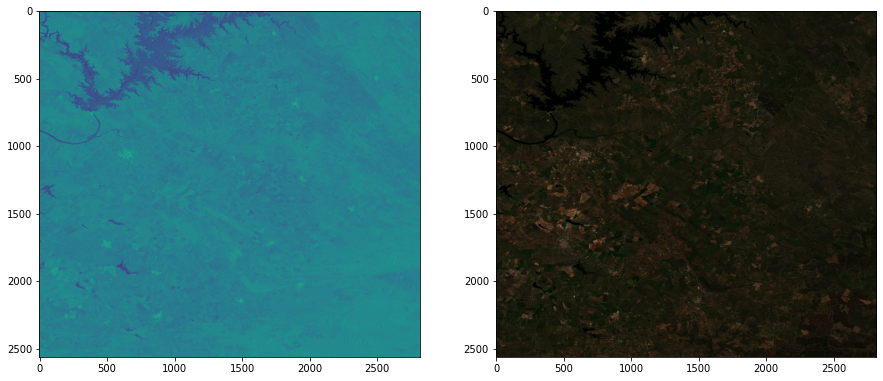

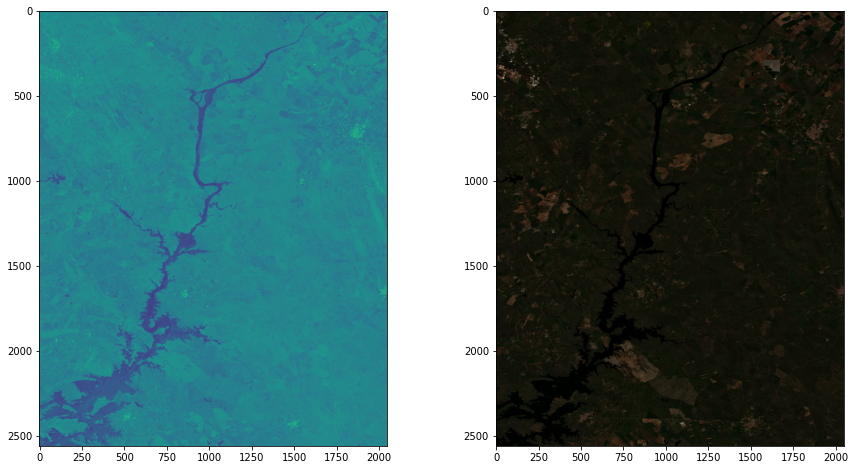

In [ ]:
##Checking images plotted with imshow
##Write function to normalize images to 0-1 scale for RGB plotting
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

##print a few
for i in range(0, len(sen1_fixed)):

  sen1_colorized = np.transpose(sen1_fixed[i])

  figure, ax = plt.subplots(ncols = 2, figsize = (15,8))
  show(sen1_fixed[i].read(1), ax = ax[0])
  show(normalize(sen2_projected[i].read([3,2,1])), ax = ax[1])
  plt.show()

##Cloud Generation

The goal of this project is to use SAR image data to fill in optical data that is not available due to cloud coverage. To assess the validity of any model we create, we need both a baseline image with no clouds and an image with clouds. As such, we need to synthesize "clouds" on the complete image. Cloud shape is no doubt important, but for the purposes of this assessment, we will focus on circular clouds. These "clouds" are created by defining a circular raster mask that covers some percentage of the image and setting the pixel values in all bands below this cloud to zero. Not all real clouds completely remove pixel intensity; however, the worst of them do. If our model can work on these "worst" case scenarios, it should be able to work with all cloud cases.

Land type, cloud size, and cloud shape are important for analysis; however, we focus on land type due to time restraints. To understand the impact of land type, we generate ten random circular clouds that cover 10% of the whole image. Randomly placing the clouds lets us asssess the models ability to capture optical data given a random subset of land (difference in vegetation, water content, terrain, etc.). However, the geography in each image will be somewhat consistent; for a more robust analysis images at different geographic locations should be tested. We do not perform this analysis due to time restraints.  


In [ ]:
##import relevant packages and functions
import rasterio.mask
from matplotlib.patches import Ellipse
from shapely.geometry import Polygon 
import geopandas as gpd

##write a function to select a random center of a cloud not within 40% of the borders
def select_center(raster, y_pad, x_pad, seed=None):

  """
  This function will randomly select center of cloud by randomly selecting from pixels in raster,
  but we do not want a cloud to overlap too much with edges, so we do not allow selection of pixels
  within *padding_perc* of the edges to be selected. Thus, the edges of clouds can be on the edge of an image, but
  the center cannot.

  Input:
  raster: input raster object
  y_pad: Pixel padding for the y coordinate (to prevent overlap with edges)
  x_pad: pixel padding for the x coordinate (to prevent overlap with the edges)
  seed: seed for random selection of center for reproducibility (Optional)

  Output:
  center_coord: The images center spatial coordinates (not just pixels)
  center_pixel: The images center in pixel indices
  
  """

  ##If we wis to set the seed, we can
  if seed is not None:
    np.random.seed(seed)

  # if (padding_perc < 0 or padding_perc > 1):
  #   raise ValueError('padding_perc must be between 0 and 1')

  ##image height and width. Used for identifying the center of the cloud
  ##Note that plotted images are reverse (origin is at top left)
  ##So im_width is actually the y coordinate and higher values are on the bottom of the image
  ##and im_height is actually the x coordinate and higher values are on the right of the image
  im_width = raster.width ##image width
  im_height = raster.height ##image height

  ##Randomly select center of cloud by randomly selecting from pixels in raster (again y is width and x is height)
  ##We need the spatial coordinate center, not just pixel center, so we use raster's raster.xy method
  ##We won't allow the center to be within *padding_perc* of the width/height so that the edges of the cloud
  ##of the cloud can overlap with edges of the image but the center cannot
  center_y_ind = np.random.randint(y_pad, im_width - y_pad) #im_width is y
  center_x_ind = np.random.randint(x_pad, im_height - x_pad) #im_height is x
  center_pixel = (center_x_ind, center_y_ind) # get center pixel coordinates
  center_coord = raster.xy(center_x_ind, center_y_ind) ##get center spatial coordinates (not just pixels)

  return center_coord, center_pixel

##Write a function to automate single, random cloud shape in an image
##Method adapted from here:
##https://scicomp.stackexchange.com/questions/35742/generate-random-smooth-2d-closed-curves

def make_clouds(raster, output_tif_circle, shape_file_circle, perc_covered, save_circle, numpy_cloud_mask, output_numpy_file, center_seed = None):

  """
  This function takes an input raster object and randomly synthesizes a 'random' cloud shape
  within the coordinate region of the supplied raster object. The cloud is generated
  by performing a linear combination of random sinusoids that vary about a radius of a circle (in polar coordinates),
  using this combination as a new "radius" or an object, and converting this radius from polar to cartesian
  coordinates to map onto the raster's coordinate system. As such, all clouds are some random disturbance about a circle.

  It also generates a circular cloud such that this circular cloud is the smallest circle that can surround the random cloud above.

  The cloud shapes are generated and then placed on the image using raster's masking operation

  Lastly, if numpy_cloud_mask is set to True, it outputs a numpy array (same size as image) where the values are 0 
  if there is no cloud and 1 if there is a cloud in the index. We define a pixel as a "cloud" pixel if the pixel is 
  within the smallest bounding box of the cloud circle (aka there will be some pixels set as "clouds" 
  when they are not actually since it is a box around a circle)

  This function requires:
    import rasterio.mask
    from matplotlib.patches import Ellipse
    from shapely.geometry import Polygon 
    import geopandas as gpd

  Inputs:
  raster: Input raster object where the cloud will go
  output_tif_circle: path to output image with circular cloud generated
  shape_file_circle: path to output shape file for circular cloud vertices
  save_circle: Whether to save circle or not (don't need to save if we are generating new shapes for future shape comparison analysis)
  numpy_cloud_mask: Logical for whether to generate a numpy array (same size as image) with values equal to 0 if no cloud is present and 1 if cloud is present
  center_seed: Seed to use for generating the center of the cloud

  Output:
  output_tif_circle: Generates a file at output_tif with the original raster containing the cloud AND a shape file with the cloud vertices.
  output_numpy_file: If numpy_cloud_mask == T, also saves a numpy array with values equal to 0 if no cloud is present and 1 if present to output_numpy_file
  """

  ############-DEFINING CIRCLE CLOUD RADIUS-################
  
  ##image height and width. Used for identifying the center of the cloud
  ##Note that plotted images are reverse (origin is at top left)
  ##So im_width is actually the y coordinate and higher values are on the bottom of the image
  ##and im_height is actually the x coordinate and higher values are on the right of the image
  # im_width = raster.width ##image width
  # im_height = raster.height ##image height

  ##Identify image coordinate range so that we can define the cloud within the coordinate range of the input raster
  x_range = raster.bounds.right - raster.bounds.left
  y_range = raster.bounds.top - raster.bounds.bottom

  ##Get x and y values of a circle centered around the center_coord above that 
  ##has a radius which yields a circle covering the percentage of area specified in the arguments
  ##This area must be specified in spatial coordinates NOT pixel values
  ##percentage must be between 0 and 1
  if (perc_covered < 0 or perc_covered > 1):
    raise ValueError('Percentage Covered must be between 0 and 1')
    
  image_area = x_range * y_range ##pixel area of the image
  r_circ = np.sqrt((perc_covered *image_area)/np.pi) ##calculate radius of circle that covers the area percentage specified

  ######################-CONVERT POLAR COORDINATES TO CARTESIAN-#####################
  
  ##Construct x and y values in the cartesian coordinate system
  ##from the radius times the cos/sin of t (ie convert from polar to cartesian coordinates)

  ##Define the range (in radians) over which we will vary the radius
  ##This lets us vary a circle's radius with sinusoids (from 0-2pi in radians)
  t = np.linspace(0,2*np.pi,101); ##generate 101 values over the circle
  
  ##define x_pad and y_pad such that the center of the circle cannot be placed within 
  ##the radius of the circle (in pixels, so we need to find in pixels)
  image_area_pixels = raster.width * raster.height
  r_circ_pixels = np.sqrt((perc_covered *image_area_pixels)/np.pi)
  x_pad = r_circ_pixels; y_pad = r_circ_pixels

  ##Define center of cloud (randomly selected to be some point not within the circle's radius of the edge)
  ##select center gives both the spatial and pixel center, so we select both

  ##Let us choose if we wish to set the seed for center selection
  if center_seed is None:
    center_coord, center_pixels = select_center(raster = raster, x_pad = x_pad, y_pad = y_pad)
  else:
    center_coord, center_pixels = select_center(raster = raster, x_pad = x_pad, y_pad = y_pad, seed = center_seed)
  
  ##x and y values for circle centered around the center defined above
  x_circ = np.squeeze(r_circ * np.cos(t) + center_coord[0]) ##x values of bounding circle
  y_circ = np.squeeze(r_circ * np.sin(t) + center_coord[1]) ##y values of bounding circle


  #######################-CREATE POLYGONS FOR MASKING RASTER-#########################

  ##Create Polygon shape for the circle cloud to mask the raster
  vertices_circ = np.column_stack([x_circ.tolist(), y_circ.tolist()]) ##'vertices' of circle
  mask_geometry_circ = Polygon(vertices_circ) ##turn to circle

  ##Create a shapefile dataframe/dictionary with GeoPandas
  mask_df_circ = gpd.GeoDataFrame({"id":1,"geometry":[mask_geometry_circ]}) ##shape df for circle

  r_cloud_circ, r_cloud_circ_transf = rio.mask.mask(raster, mask_df_circ["geometry"], crop=False, invert = True) ##mask out circle "cloud"
  r_meta_2 = raster.meta ##extract metadata for saving
  r_meta_2.update({"driver": "GTiff", ##create additional metadata for saving
                  "height": r_cloud_circ.shape[1], ##image height
                  "width": r_cloud_circ.shape[2], ##image width
                  "transform": r_cloud_circ_transf}) ##new transform

  ###################-SAVE IMAGES AND SHAPES-###################

  ##save image/shape with circle cloud if needed
  if save_circle == True:

    ##cloud image
    with rio.open(output_tif_circle, "w", **r_meta_2) as dest:
      dest.write(r_cloud_circ)

  ###################-CREATE BOOLEAN ARRAY FOR CLOUD LOCATION-######################

  ##If numpy_cloud_mask == True, we output a numpy array (same size as image)
  ##where the values are 0 if there is no cloud and 1 if there is a cloud as the index
  ##We define a pixel a "cloud" pixel if the pixel is within the smallest bounding
  ##box of the circle (aka there will be some pixels set as "clouds" when they are not since it is a box around a circle)

  if numpy_cloud_mask == True:

    ##get inverted mask so that only cloud pixels are returned and the rest are set to False
    ##Setting filled = False returns boolean for non-cloud region
    nodata_val = np.max(raster.read() + 1)##setting cloud value outside normal range of rasters
    numpy_mask, _ = rio.mask.mask(raster, mask_df_circ["geometry"], nodata = nodata_val, ##setting cloud value outside normal range of rasters
                                  crop=False, invert = True) ##mask out circle "cloud"
    numpy_mask = np.where(numpy_mask == nodata_val, 1, 0)[0] ##Only need one array because it is consistent for all bands

    np.save(output_numpy_file, numpy_mask, allow_pickle=True)
    



  




In [ ]:
##Use the make_clouds function to make clouds for all sentinel_2 data
##Need to randomly "shuffle" the cloud location 10 times (more would be better)
##to get an assessment of the true RMSE and variability

#########################-DIRECTORY CREATION-################################

sen2_cloud_circ_dir = data_dir + "/sen2_circle_cloud/"
shape_circle_dir = data_dir + "/circle_cloud_shapes/"
numpy_mask_dir = data_dir + "/numpy_cloud_masks/"


##sen2 circle cloud dir create
if not os.path.exists(sen2_cloud_circ_dir):
  
  #Create a new directory because it does not exist 
  os.makedirs(sen2_cloud_circ_dir)
  print("The new directory is created!")

##Circle cloud shape dir create
if not os.path.exists(shape_circle_dir):
  
  #Create a new directory because it does not exist 
  os.makedirs(shape_circle_dir)
  print("The new directory is created!")


##Numpy cloud mask directory create
if not os.path.exists(numpy_mask_dir):
  
  #Create a new directory because it does not exist 
  os.makedirs(numpy_mask_dir)
  print("The new directory is created!")


##############################-DATA GENERATION-################################
##set seeds for reproducibility
seed = 92

##number of clouds to generate
n_clouds = 10

##Loop through sen2 images to randomly add clouds (and circle clouds)
for i in range(0, len(sen2_images)):

  ##Make directory for sen2_image
  pattern_name =re.search(r'aoi_[0-9]+', sen2_images[i]).group() ##image pattern aka aoi_[number]
  output_image_dir = sen2_cloud_circ_dir + f"{pattern_name}_clouds/"
  output_shape_dir = shape_circle_dir + f"{pattern_name}_cloud_shapes/"
  output_numpy_dir = numpy_mask_dir + f"{pattern_name}_numpy_masks/"

  print(f"Image: {pattern_name}")

  if not os.path.exists(output_image_dir):
  
    #Create a new directory because it does not exist 
    os.makedirs(output_image_dir)
    print("The new directory is created!")

  if not os.path.exists(output_shape_dir):
  
    #Create a new directory because it does not exist 
    os.makedirs(output_shape_dir)
    print("The new directory is created!")

  if not os.path.exists(output_numpy_dir):
  
    #Create a new directory because it does not exist 
    os.makedirs(output_numpy_dir)
    print("The new directory is created!")


  ##generate clouds with the make_clouds function. 
  np.random.seed(seed)

  for j in range(n_clouds):

    ##Output files for circle cloud shapes
    output_tif_circle = output_image_dir + f"cloud{j+1}_" + sen2_images[i]
    shape_file_circle = output_shape_dir + f"cloud_shape{j+1}_" + re.sub(".tif" , ".shp", sen2_images[i])

    ##Output files for numpy cloud mask array
    output_numpy_file = output_numpy_dir + f"numpy_cloud_mask{j+1}_" + pattern_name + ".npy" ##numpy array file name

    ##make first circle cloud and shape (Also get the numpy cloud mask to tell which pixels are clouds)
    make_clouds(raster = sen2_projected[i],
                output_tif_circle = output_tif_circle, shape_file_circle = shape_file_circle,
                perc_covered = 0.1, save_circle = True, numpy_cloud_mask = True, 
                output_numpy_file = output_numpy_file, center_seed = None)

  

The new directory is created!
Image: aoi_1
The new directory is created!
Image: aoi_2
The new directory is created!


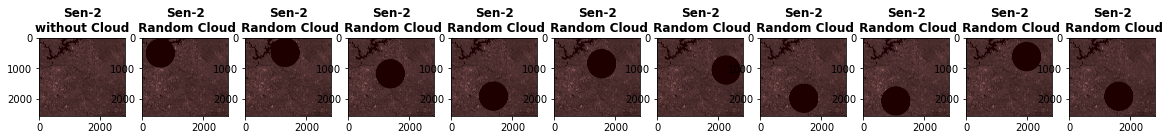

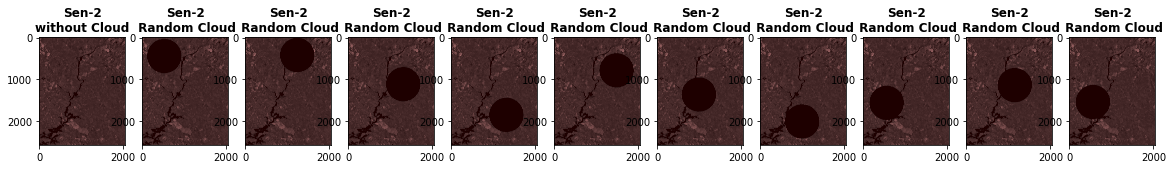

In [ ]:
##Read in circle cloudy images for each image

##Get directories for each image
sen2_cloud_dirs = [f for f in natsorted(os.listdir(sen2_cloud_circ_dir))] ##load directory names

##Get all clouds for each imge
sen2_cloud_files = [None] * len(sen2_cloud_dirs) ##initialize list for cloud files
# sen2_clouds = {None} * len(sen2_cloud_dirs) ##initialize list for cloud images
sen2_clouds = {}
pattern_names = ["aoi_" + str(i+1) for i in range(len(sen2_cloud_dirs))]

for i in range(len(sen2_cloud_dirs)):
  sen2_cloud_files[i] = [join(sen2_cloud_circ_dir, sen2_cloud_dirs[i], f) for f in natsorted(os.listdir(join(sen2_cloud_circ_dir, sen2_cloud_dirs[i])))]
  image_pattern = pattern_names[i]
  sen2_clouds[image_pattern] =  [rio.open(f) for f in sen2_cloud_files[i]]## read sen2 cloud files into a list of lists

##show images
for i in range(len(sen2_clouds)):
  figure, ax = plt.subplots(ncols = n_clouds + 1, figsize = (20,15))

  show(sen2_projected[i].read([1]), ax = ax[0], title = "Sen-2\nwithout Cloud", cmap = "pink")
  for j in range(n_clouds):
    image_pattern = pattern_names[i]
    show(sen2_clouds[image_pattern][j].read([1]), ax = ax[j + 1], title = "Sen-2\n Random Cloud", cmap = "pink")
  plt.show()

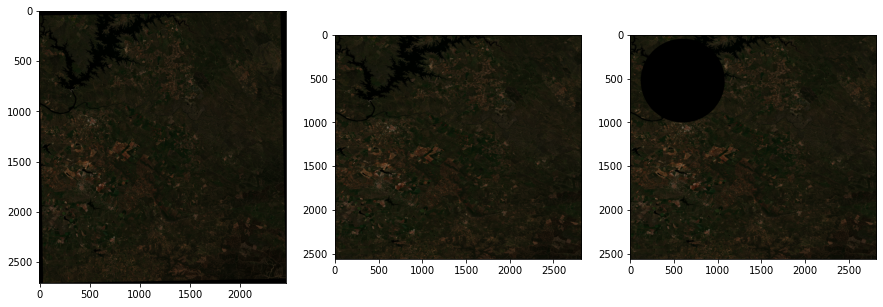

In [ ]:


RGB_order = [3,2,1]
fig, ax = plt.subplots(ncols = 3, figsize = (15,8))
ax[0].imshow(normalize(np.transpose(sen2_datasets[0].read(RGB_order), (1,2,0))))
ax[1].imshow(normalize(np.transpose(sen2_projected[0].read(RGB_order), (1,2,0))))
ax[2].imshow(normalize(np.transpose(sen2_clouds["aoi_1"][0].read(RGB_order), (1,2,0))))


##Traditional Model Feature Generation

We are testing both traditional models (Linear, Decision Tree Regressor, and Light Gradient Boosting Regressor) and a deep learning network (Supervise CycleGAN). While the deep learning network can simply take an image as input, the traditional models needs and outcome variable and feature matrix. For the traditional models, we propose developing an individual model for each band within the sentinel-2 image (red, green, blue, nir). Our input (feature matrix) will contain SAR pixel intensities and the outcome will be an individual pixel intensity. We cannot assume that the mapping between SAR data and optical pixel intensity will be the same for each image (due to geography, land cover, seasonality, time of day, etc.) and or for each band (there may be a stronger relationship between radio waves and given visual spectrum wavelengths of light). 

The feature matrix must be a set of features expected to be related to an individual pixel intensity for a given band. The proposed feature matrix contains 9 variables for each SAR input, so with 3 input bands (VV, VH, VV/VH), there will be 27 variables. The 9 input values per band are 1) the corresponding SAR band pixel for the outcome (ie overlapping) and 2-9) the 8 SAR pixels surrounding the overlapping pixel (pixels are squares, so there are 8 surrounding the central/overlapping pixel). The idea here is that images are structurally dependent, so local pixel intensities are likely related to the pixel of interest. Using further surrounding pixels is potentially useful, however, since each training set will have potentially millions of pixels, minimizng the number of features is critical for computational purposes.

To define the pixel and feature set, we will randomly select 200,000 pixels of interest (we subset the pixels for computational purposes) per image and then, using the indices of these selected pixels, select the surrounding 8 pixels per band (for SAR) 

In [ ]:
##Write a function to quickly sample sample_size from N total size
##compared with random.choice and random.shuffle and it was much faster for large samples
def fast_chooser(size, num_samples, replace):
  rng = np.random.default_rng()
  return rng.choice(size, num_samples, replace=replace)

##write a function to randomly select pixel indices to use for training (from 2D array)
def select_train_test_indices(cloud_mask, sample_size):
  """
  This model will select n pixels (indices of these pixels) to use for training
  The pixels can be anywhere except on the edge of the image (because our model uses the surrounding
  pixels to predict) or in the cloud. We know approximately where the cloud is based on the "cloud_mask",
  which is the smallest bouding square around the clouds. 

  The cloud pixels are left for validation

  Input:
  cloud_mask: a 2D boolean array with same dimensions as the image. 
  There is a 1 if a pixel is in a cloud and a 0 if the pixel is not in a cloud
  sample_size: number of samples (indices) to include in train set

  Output:
  train_ind: selected 2D indices (tuple of arrays: row_ind, col_ind)
  """

  ##create list object with possible one dimensional indices chosen
  ##one dimensional indices are 0:array.size
  ##Cannot choose from those that are in the first or last row
  ##(ie from 0 to (width-1) or from size-(width+1) to size)
  row, col = cloud_mask.shape ##get dims
  size = col*row ##need size integers
  max = size-col ##max possible 1D index to choose (non-inclusive when using range, so this isn't included)
  possible_range = range(col, max) ##goes from col = first in second row to max-1 = last in second to last row

  ##Also cannot choose when i % width == 0 (left edge) OR when i % width == 1 (right edge)
  not_edges = [i for i in possible_range if not(i % col == 0 or i % col == (col-1))]

  ##convert cloud mask to one dimensional array (ravel it) and subset the portion that is not on the edge
  cloud_mask_ravel = np.ravel(cloud_mask)
  cloud_mask_ravel = cloud_mask_ravel[not_edges]

  ##Now subset the "possible_range" to not include any one dimensional cloud indices
  ##which yields a list of possible indices not including edges or clouds
  ##(Must convert to array to be able to index by np.where)
  not_edges_or_cloud = np.array(not_edges)[np.where(cloud_mask_ravel == 0)[0]]

  ##choose one dimensional indices
  if sample_size > len(not_edges_or_cloud):
    raise ValueError(f"Total size not including edges is {len(not_edges_or_cloud)}. Cannot choose sample size larger than this to avoid duplicate indices.")

  one_dim_indices = fast_chooser(not_edges_or_cloud, sample_size, replace = False) ##choose random one-dim indices for train

  ##Now we unravel the one-dimensional train and test indices to two-dim indices (tuple of arrays)
  train_ind = np.unravel_index(one_dim_indices, shape = (row, col)) ##train

  # one_dim_indices = np.random.choice(not_edges_or_cloud, sample_size, replace = False) ##choose random one-dim indices for both train and test

  ##split test/train indices into train and test based on train_perc
  # n_train = np.round(train_perc*sample_size).astype(int)
  # train_sel = fast_chooser(sample_size, n_train, replace = False)##select n_train integers between 0 and n (which will let us select train_perc from one_dim_indices)
  # # train_sel = np.random.choice(range(0,sample_size), n_train, replace = False) ##select n_train integers between 0 and n (which will let us select train_perc from one_dim_indices)

  # ##create boolean mask to select train
  # train_mask = np.zeros((sample_size)).astype(bool)  ##first create zero matrix and convert to bool
  # train_mask[train_sel] = True ##next set chosen training indices to True

  # ##create boolean mask to select test
  # test_mask = np.ones((sample_size)).astype(bool) ##create one matrix and convert to bool
  # test_mask[train_sel] = False ##Set the chosen training indices to false

  ##select train indices
  # train_ind_one_dim = one_dim_indices[train_mask]
  # test_ind_one_dim = one_dim_indices[test_mask]


  # train_ind = np.unravel_index(train_ind_one_dim, shape = (row,col)) ##train
  # test_ind = np.unravel_index(test_ind_one_dim, shape = (row,col)) ##test
  # ind_select = np.unravel_index(one_dim_indices, shape = (row,col))

  return train_ind





##writing a function to select the feature variables given a chosen pixel index for optical output

def select_feature_indices(center_pixel_index):
  """
  This function takes a center pixel (chosen pixel) index, finds the indices of the square surrounding
  that pixel, and returns the indices in the order: 
  top_left, top, top_right, left, center, right, bottom left, bottom, bottom right

  Input:
  center_pixel_index: tuple for center index (row, col)

  Output: 
  feature_indices: tuple of arrays where the first array contains the row indices and the second array contains the 
                   column indices of the selected feature vectors. The order within the arrays will allways be:
                   top_left, top, top_right, left, center, right, bottom left, bottom, bottom right 
                   (9 for the center and surrounding pixels)
  """

  ##Get the row indices
  center_row = center_pixel_index[0] ##center row index
  row_array = np.array([center_row - 1, center_row - 1, center_row - 1,
                        center_row, center_row, center_row,
                        center_row + 1, center_row + 1, center_row + 1])
  
  ##Get the col indices
  center_col = center_pixel_index[1] ##center col index
  col_array = np.array([center_col - 1, center_col, center_col + 1,
                        center_col - 1, center_col, center_col + 1,
                        center_col - 1, center_col, center_col + 1])
  
  ##combine row and col indices into tuple of arrays (format used by numpy for indexing 2d arrays)
  feature_indices = (row_array, col_array)

  return feature_indices



In [ ]:
# ##List file names for numpy masks
# cloud_mask_f = [f for f in os.listdir(numpy_masks_dir) if isfile(join(numpy_masks_dir, f))]
# mask_number = [re.search(r'(?<=_)[0-9]+', i).group() for i in cloud_mask_f] ##gets ao1 number for image (aoi_{number})
# cloud_mask_f = [cloud_mask_f[i] for i in index_natsorted(mask_number)] ##sorts according to sorted image number (aoi_{number})

# ##Read in numpy cloud masks (array to tell us whether a pixel is part of a cloud or not)
# ##(0 if no cloud on the pixel and 1 if cloud is on the pixel)
# cloud_mask_arrays = [np.load(join(numpy_masks_dir,f), allow_pickle=True) for f in cloud_mask_f]



## Linear Model Train and Test Sets

Now we generate the training and testing datasets (y, X matrix) for each linear model described above

In [ ]:
def generate_train_test(sen1_image, sen2_image, cloud_mask, sample_size, sen2_RGBA_band_order):
  """
  This function takes sentinel-1 and sentinel-2 images from image format and turns them into 
  a 1) design/feature matrix (sentinel-1) and 2) outcome variable (sentinel-2) that are split into train and test sets
  according to sample_size and train_percent. The train and test sets do NOT include any pixels with clouds. These will be
  used for a separate validaiton set.

  First the function selects the indices of the outcome (y) pixels in sentinel-2 for train and test. Then, using these indices,
  it finds the corresponding value in Sentinel-1 VV, VH, and VV/VH bands. Next it finds the pixel values to the
  top left, top, top right, left, right, bottom left, bottom, and bottom right of the central pixel and includes them in
  the design matrix as well. It does this for VV, VH, and VV/VH, so there are 27 variables per selected pixel.

  Lastly, we are building a model for each color band in Sentinel-2, so we extract the outcome (y) for each
  band individually to give y_red, y_green, y_blue, y_nir

  Input:
  sen1_image: Full image array for sentinel-1
  sen2_image: Full image array for sentinel-2
  cloud_mask: Boolean mask telling whether a pixel is a cloud (1) or not (0) in the image array
  sample_size: Size of train set we wish to use
  sen2_RBGA_band_order: A list that specifies the location of the red, green, blue, and nir (A) channels in sentinel 2

  Output:
  Train: a train matrix y_red, y_green, y_blue, y_nir, {VV selected pixels}, {VH selected pixels}, {VV/VH selected pixels}
         where VV, VH, VV/VH are in order: 
         top left, top, top right, left, center (outcome location), right, bottom left, bottom, bottom right
  Test: A test matrix with same dimensions as Train but with only cloud data
  """

  ##Find train indices
  train_ind= select_train_test_indices(cloud_mask, sample_size)

  #Get the cloud/test indices
  cloud_ind = np.where(cloud_mask == 1) ##get numerical indices for cloud

  ##unpack sen2 output by color and subset train/test (subtract by one to get from raster to numpy indexing)
  ##(Need to reshape to ensure there are TWO dimensions match dimensions of X_Train for the concatenation step)
  y_train_red, y_train_green, y_train_blue, y_train_nir = [sen2_image[band-1,:,:][train_ind].reshape(-1,1) for band in sen2_RGBA_band_order]
  y_test_red, y_test_green, y_test_blue, y_test_nir = [sen2_image[band-1,:,:][cloud_ind].reshape(-1,1) for band in sen2_RGBA_band_order]


  ##get list of feature vectors indices for EACH observation

  ##Train

  ##We can get the feature vector for ONE observation by putting the center pixel into select_feature_indices
  ##To get the list use a list comprehension for EACH pixel in train_ind/test_ind
  row, col = [vector.tolist() for vector in train_ind] ##separate row data and col data into two lists
  center_tuples = [(i, j) for i, j in zip(row, col)] ##make individual tuples for each row, col pair
  feature_indices_list = [select_feature_indices(ind) for ind in center_tuples] ##get feature indices for EACH selected pixel

  ##Create X_train by concatenating (colwise) the feature indices for vv vh and vv/vh for each observation
  X_train = [np.concatenate((sen1_image[0,:,:][ind], sen1_image[1,:,:][ind],sen1_image[2,:,:][ind])) for ind in feature_indices_list]
  X_train = np.stack(np.array(X_train), axis = 0) ##Stack list of individual feature observations rowwise to make X_train

  ##Test/Validation

  ##Get true values for cloud image data (outcome)
  y_test_red, y_test_green, y_test_blue, y_test_nir = [sen2_image[band-1,:,:][cloud_ind].reshape(-1,1) for band in sen2_RGBA_band_order]

  ##We can get the feature vector for ONE observation by putting the center pixel into select_feature_indices
  ##To get the list use a list comprehension for EACH pixel in train_ind/test_ind
  row, col = [vector.tolist() for vector in cloud_ind] ##separate row data and col data into two lists
  center_tuples = [(i, j) for i, j in zip(row, col)] ##make individual tuples for each row, col pair
  feature_indices_list = [select_feature_indices(ind) for ind in center_tuples] ##get feature indices for EACH selected pixel

  ##Create X_val by concatenating (colwise) the feature indices for vv vh and vv/vh for each observation
  X_test = [np.concatenate((sen1_image[0,:,:][ind], sen1_image[1,:,:][ind],sen1_image[2,:,:][ind])) for ind in feature_indices_list]
  X_test = np.stack(np.array(X_test), axis = 0) ##Stack list of individual feature observations rowwise to make X_val (cloud input)


  ##Make datasets with y and X together (y in the order or y_red, y_green, y_blue, y_nir)
  train = np.concatenate((y_train_red, y_train_green, y_train_blue, y_train_nir, X_train), axis = 1)
  test = np.concatenate((y_test_red, y_test_green, y_test_blue, y_test_nir, X_test), axis = 1)

  return train, test

In [ ]:
##Get the cloud mask file names for defining the training and test est
numpy_masks_dir = data_dir + "/numpy_cloud_masks/"
numpy_masks_images = [numpy_mask_dir + f"{name}_numpy_masks" for name in pattern_names]

##Get all clouds for each image
cloud_mask_f = [None] * len(numpy_masks_images) ##initialize list for cloud files

for i in range(len(numpy_masks_images)):
  cloud_mask_f[i] = [join(numpy_masks_images[i], f) for f in natsorted(os.listdir(numpy_masks_images[i]))] ##get file names for each image

In [ ]:
##Get training and test sets for each image (within the set contains the y/outcome for each individual sen2 color model)

##Make output directories
lin_mod_directory = join(data_dir, "Linear_Model_Data")

##Make directory only if it doesn't already exist
if not os.path.exists(lin_mod_directory):
  os.mkdir(lin_mod_directory)
  print("The new directory is created!")


###############################################################################

##Setup color extraction in the correct order
sen2_RGBA_band_order = [3,2,1,4] ##3 is Red, 2 is Green, 1 is Blue, 4 is NIR

##use for loop to generate the train and test sets
sample_size = 1000000 ##set sample size for training set
np.random.seed(420)##set seed for reproducibility


##First loop over each image
for i in range(len(sen1_fixed)):

  ##Create final output directories
  image_dir = join(lin_mod_directory, f"aoi_{i+1}_data")
  train_dir = join(image_dir, f"aoi_{i+1}_training")
  test_dir = join(image_dir, f"aoi_{i+1}_testing")

  for dir in [image_dir, train_dir, test_dir]:
  
    ##Make directory only if it doesn't already exist
    if not os.path.exists(dir):
      os.mkdir(dir)
      print("The new directory is created!")


  ##Then loop over each cloud image
  for j in range(n_clouds):
    print(f'Image/Mask: aoi_{i+1}/Mask_{j+1}')

    ##load cloud mask and generate train/test for each image and cloud mask
    cloud_mask = np.load(cloud_mask_f[i][j])
    train_sets, test_sets = generate_train_test(sen1_fixed[i].read(), sen2_projected[i].read(), cloud_mask, 
                                                sample_size = sample_size, 
                                                sen2_RGBA_band_order = sen2_RGBA_band_order)
    
    ##Save train/test for each image and cloud mask

    ##Make output file path
    train_path = join(train_dir, f"aoi_{i+1}_mask{j+1}_training.npy")
    test_path = join(test_dir, f"aoi_{i+1}_mask{j+1}_testing.npy")

    ##Save numpy arrays
    np.save(train_path, train_sets)
    np.save(test_path, test_sets)


# train_sets, test_sets = zip(*zip([generate_train_test(sen1.read(), sen2.read(), cloud_mask, 
#                                                   sample_size = 50000, train_percent = 0.9, 
#                                                   sen2_RGBA_band_order = sen2_RGBA_band_order) for sen1, sen2, cloud_mask in zip(sen1_fixed, sen2_projected, cloud_mask_arrays)]))

Image/Mask: aoi_1/Mask_1
Image/Mask: aoi_1/Mask_2
Image/Mask: aoi_1/Mask_3
Image/Mask: aoi_1/Mask_4
Image/Mask: aoi_1/Mask_5
Image/Mask: aoi_1/Mask_6
Image/Mask: aoi_1/Mask_7
Image/Mask: aoi_1/Mask_8
Image/Mask: aoi_1/Mask_9
Image/Mask: aoi_1/Mask_10
The new directory is created!
The new directory is created!
The new directory is created!
Image/Mask: aoi_2/Mask_1
Image/Mask: aoi_2/Mask_2
Image/Mask: aoi_2/Mask_3
Image/Mask: aoi_2/Mask_4
Image/Mask: aoi_2/Mask_5
Image/Mask: aoi_2/Mask_6
Image/Mask: aoi_2/Mask_7
Image/Mask: aoi_2/Mask_8
Image/Mask: aoi_2/Mask_9
Image/Mask: aoi_2/Mask_10
The new directory is created!
The new directory is created!
The new directory is created!
Image/Mask: aoi_3/Mask_1
Image/Mask: aoi_3/Mask_2
Image/Mask: aoi_3/Mask_3
Image/Mask: aoi_3/Mask_4
Image/Mask: aoi_3/Mask_5
Image/Mask: aoi_3/Mask_6
Image/Mask: aoi_3/Mask_7
Image/Mask: aoi_3/Mask_8
Image/Mask: aoi_3/Mask_9
Image/Mask: aoi_3/Mask_10
The new directory is created!
The new directory is created!
The new